## Data Wrangling & Exploratory Data Analysis: Chatbot 'Yoldi' 

This notebook encompasses the initial stages of developing a chatbot, 'Yoldi', designed to automate responses for multiple brands on social media platforms. The key steps in this notebook include:

### 1. Data Acquisition
- **Objective**: Load the dataset from the database sampling 250k records for chatbot development. Whole dataset for scaling the project might be possible. 
- **Methodology**: ETL pipeline creation - Use PostgreSQL to create a database, called customer_support, create the schema and set it up. Then, upload the csv file to the database. Finally, use SQL to load the dataset with aggregation and optimize  processing. 

### 2. Data Wrangling and Cleaning
- **Objective**: Prepare the dataset for analysis and model training.
- **Steps Involved**:
  - Filter out inbound queries(users) and responses from Customer Support.
  - Handle missing data, duplicates, and other data inconsistencies.
  - Cleaning text data tecniques with regex and advanced NLP with SpaCy and NLTK.
  - Link user queries with corresponding Customer Support responses.

### 3. Exploratory Data Analysis (EDA)
- **Objective**: Gain insights from the data through visualization and basic statistics.
- **Techniques Used**:
  - Visualize the distribution of queries over time.
  - Analyze the common themes or topics in customer queries.
  - Understand the response patterns of Customer Support.

### 4. Initial Data Insights
- **Objective**: Draw preliminary conclusions from the EDA.
- **Key Areas**:
  - Understanding the nature and complexity of queries.
  - Assessing the efficiency of customer support responses.


In [2]:
import logging
import html
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import nltk
import dotenv
import re
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import plotly.express as px
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, String, Boolean, DateTime
import psycopg2
from gensim import corpora
from gensim.models import LdaMulticore, CoherenceModel
from gensim.corpora.dictionary import Dictionary

#### Data Acquisition: PostgreSQL

In [ ]:
# Fetching the password from environment variable
db_password = os.environ.get('DATABASE_PASSWORD')

# Ensure the password is set
if db_password is None:
    raise ValueError("Database password environment variable not set")

# Database connection details
username = 'postgres'  # replace with your username
host = 'localhost'
database = 'customer_support'
db_password = 'DATABASE_PASSWORD'

# Creating database connection URL
db_url = f"postgresql://{username}:{db_password}@{host}/{database}"

# Create a database engine
engine = create_engine(db_url)

# testing the connection
try:
    with engine.connect() as conn:
        print("Successfully connected to the database!")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# creating table - define metadata
metadata = MetaData()

# Define the 'tweets' table
tweets_table = Table('tweets', metadata,
                     Column('tweet_id', Integer, primary_key=True),
                     Column('author_id', String),
                     Column('inbound', Boolean),
                     Column('created_at', DateTime),
                     Column('text', String),
                     Column('response_tweet_id', Integer),
                     Column('in_response_to_tweet_id', Integer)
                    )

# creating the table
metadata.create_all(engine)

In [ ]:
conn_info = "dbname='customer_support' user='postgres' host='localhost' password='DePorLo*****'"
conn = psycopg2.connect(conn_info)
cur = conn.cursor()

with open('../data/raw/twcs.csv', 'r') as f:
    cur.copy_expert("COPY tweets FROM STDIN WITH CSV HEADER", f)
    conn.commit()

cur.close()
conn.close()

In [9]:
dotenv_path = os.path.join(os.getcwd(), '.env')
# Load the .env file
dotenv.load_dotenv(dotenv_path)

# Retrieve the environment variable
db_password = os.environ.get('DATABASE_PASSWORD')
if db_password is None:
    raise ValueError("Database password environment variable not set")
else:
    print("Database password loaded successfully")

Database password loaded successfully


In [4]:
DB_USERNAME = 'postgres'
DB_PASSWORD = os.environ.get('DATABASE_PASSWORD')
DB_HOST = 'localhost'
DB_NAME = 'customer_support'
SAMPLE_QUERY = "SELECT * FROM tweets ORDER BY RANDOM() LIMIT 250000;"

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Function to create a database engine
def create_db_engine(username, password, host, database):
    try:
        db_url = f"postgresql://{username}:{password}@{host}/{database}"
        engine = create_engine(db_url)
        logging.info("Database engine created successfully")
        return engine
    except Exception as e:
        logging.error(f"Error creating database engine: {e}")
        raise

# Function to test database connection
def test_db_connection(engine):
    try:
        with engine.connect() as conn:
            logging.info("Successfully connected to the database")
    except Exception as e:
        logging.error(f"An error occurred while connecting to the database: {e}")
        raise

# Fetching the password from environment variable
db_password = os.environ.get('DATABASE_PASSWORD')
if db_password is None:
    raise ValueError("Database password environment variable not set")

# creating engine and testing
engine = create_db_engine(DB_USERNAME, DB_PASSWORD, DB_HOST, DB_NAME)
test_db_connection(engine)

# function to sample data
def sample_data(conn, query):
    """Sample data from the database.
    conn: connection previously created for the database.
    query: PostgreSQL query to sample the data.
    Returns: dataframe.
    """

    try:
        logging.info("Starting function execution: sample_data")
        return pd.read_sql_query(query, conn)
    except Exception as e:
        logging.error(f"Error in your_function: {e}")
        raise
    else:
        logging.info("Completed execution of function: sample_data")
    
# executing function to sample data and save it to folder as csv
sampled_data = sample_data(engine, SAMPLE_QUERY)
sampled_data.to_csv('../data/raw/df_sample.csv', index=False)


2023-11-22 20:49:02,119 - INFO - Database engine created successfully
2023-11-22 20:49:02,169 - INFO - Successfully connected to the database
2023-11-22 20:49:02,170 - INFO - Starting function execution: sample_data


### Data Loading: 

We load the data as the final stage of the ETL pipeline from the PostgreSQL database. 

In [3]:
# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# file path
file_path = '../data/raw/df_sample.csv'

#function to load
def load_data(file_path, chunk_size=1000):
    """
    Load data from a CSV file in chunks to manage memory usage.
    """
    try:
        logging.info("Starting execution of load_data")
        chunk_list = []
        for chunk in pd.read_csv(file_path, chunksize=chunk_size):
            chunk_list.append(chunk)
        df = pd.concat(chunk_list, ignore_index=True)
        logging.info("Data loading completed successfully")
        return df
    except Exception as e:
        logging.error(f"Error loading data from %s: %s:", file_path, e)
        return None

# loading data to df
df = load_data(file_path=file_path)
# checking dataframe 
df.head(10)

2023-11-24 10:53:17,745 - INFO - Starting execution of load_data
2023-11-24 10:53:18,713 - INFO - Data loading completed successfully


,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,2149594,Tesco,False,2017-11-09 00:55:53,@535047 Can you please confirm the requested d...,NaN,2149595.0
1,1561881,482478,True,2017-11-04 04:57:53,What's with the pricing @GoDaddyHelp?\n$12.96....,"1561882,1561883,1561880",NaN
2,1956537,SpotifyCares,False,2017-10-30 17:24:43,@580626 Hey Henry! It's an easter egg for the ...,NaN,1956538.0
3,1495379,AskCiti,False,2017-11-05 00:32:31,@467204 Hello. We haven't heard from u. If u s...,NaN,1495377.0
4,582530,ATVIAssist,False,2017-12-03 13:19:03,"@257338 Apologies for the delay, please provid...",NaN,582531.0
5,2077646,135058,True,2017-10-09 07:41:35,"@AppleSupport hey, I didn’t use a flashlight m...","2077647,2077645",NaN
6,1067207,371845,True,2017-10-14 20:26:51,@115888 funny how a song that brags about sayi...,1067206,NaN
7,2792850,UPSHelp,False,2017-11-21 21:08:00,"@779420 Also, with your phone number I can fil...",2792851,2792852.0
8,2181045,639075,True,2017-11-09 18:31:34,@VirginTrains Now I'm connected and slow! Not ...,2181046,2181044.0
9,2737067,comcastcares,False,2017-11-20 20:39:51,@766954 The last DM from you was in July. We w...,NaN,2737065.0


#### Data Cleaning: 

Below we clean the data as a preparation for exploring it in EDA further below.

In [4]:
# function to perform basic cleaning text for more advanced cleaning and preprocessing
def custom_clean_text(text):
    """
    Perform custom cleaning of text data.
    text (str): The text to be cleaned.
    Returns:
    str: Cleaned text.
    """
    try:
        # Decode HTML entities
        text = html.unescape(text)
        # Remove URLs
        text = re.sub(r'http\S+', '', text)
        # Remove user mentions and hashtags
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'#\w+', '', text)
        # Remove special characters
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)
        # Remove extra spaces, new lines
        text = ' '.join(text.split())
        # Convert to lowercase
        text = text.lower()
        return text
    except Exception as e:
        logging.error(f"Error in cleaning text: {e}")
        # Optionally, you can return None or some default value if error occurs
        return None

# error handling testing function
try:
    df['cleaned_text'] = df['text'].apply(custom_clean_text)
    logging.info("Text cleaning completed successfully")
except Exception as e:
    logging.error(f"Error during text cleaning process: {e}")

# dropping columns
df.dropna(subset=['text', 'created_at'], inplace=True)
df.drop_duplicates(subset=['tweet_id'], inplace=True)
df['created_at'] = pd.to_datetime(df['created_at'])

2023-11-24 10:53:44,131 - INFO - Text cleaning completed successfully


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   tweet_id                 250000 non-null  int64         
 1   author_id                250000 non-null  object        
 2   inbound                  250000 non-null  bool          
 3   created_at               250000 non-null  datetime64[ns]
 4   text                     250000 non-null  object        
 5   response_tweet_id        157212 non-null  object        
 6   in_response_to_tweet_id  179666 non-null  float64       
 7   cleaned_text             250000 non-null  object        
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 13.6+ MB


#### Advanced Text Cleaning and Initial Preprocessing with SpaCy and nltk:

Using SpaCy module, we will perform initial text preprocessing. It is crucial for the development of the chatbot for us to generate POS tagging, dependency parsing, and lemmatization. After that, we will also do a sentiment analysis as part of the EDA and other tecniques that will allow us to have a cleaner dataset and text structure so we can create some features in nex stages.

In [6]:
# initializing spacy 
nlp = spacy.load('en_core_web_sm')

In [7]:
# batch processing with spacy: advanced NLP preprocessing
def batch_spacy_preprocessing(texts, batch_size=1000):
    """
    Process a batch of texts using SpaCy for NLP tasks such as lemmatization, 
    part-of-speech tagging, and dependency parsing.
    Args:
    texts (list of str): A list of texts to be processed.
    batch_size (int): The number of texts to process in each batch.
    Returns:
    tuple: Three lists containing the processed texts, POS tags, and dependency parses.
    """
    try:
        # Load SpaCy model
        nlp = spacy.load('en_core_web_sm')
        processed_texts, pos_tags, dep_parses = [], [], []

        # Process texts in batches
        for doc in nlp.pipe(texts, batch_size=batch_size):
            if doc.is_parsed:
                doc_lemmas = [token.lemma_ for token in doc if not token.is_stop]
                doc_pos_tags = [token.pos_ for token in doc]
                doc_dep_parse = [token.dep_ for token in doc]
            else:
                doc_lemmas, doc_pos_tags, doc_dep_parse = None, None, None

            processed_texts.append(' '.join(doc_lemmas) if doc_lemmas else None)
            pos_tags.append(doc_pos_tags)
            dep_parses.append(doc_dep_parse)

        logging.info("Spacy batch processing completed successfully")
        return processed_texts, pos_tags, dep_parses
    except Exception as e:
        logging.error(f"Error in Spacy batch processing: {e}")
        # Optionally return a default value or empty lists if error occurs
        return [], [], []

# apply spacy batch processing
texts = df['cleaned_text'].astype(str).tolist()
df['processed_text'], df['pos_tags'], df['dep_parse'] = batch_spacy_preprocessing(texts)

/var/folders/fk/kvpxv24d2ys_slgf4kqk23f40000gn/T/ipykernel_55423/293729205.py:19: DeprecationWarning: [W107] The property `Doc.is_parsed` is deprecated. Use `Doc.has_annotation("DEP")` instead.
  if doc.is_parsed:
2023-11-24 11:15:58,234 - INFO - Spacy batch processing completed successfully


In [8]:
nltk.download('vader_lexicon')

# initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis to the processed text
df['sentiment'] = df['processed_text'].apply(lambda x: sia.polarity_scores(x)['compound'] if x else 0)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/camilods16/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#### Linked DataFrame:

Creating a DataFrame that link customer queries with support agent responses, this will be particulary useful in later stages of the project. 

In [9]:
# defining functions for linking customer queries with responses
def link_queries_responses(df):
    """
    Link inbound queries with their corresponding outbound responses in a DataFrame.
    df (pd.DataFrame): DataFrame containing customer support data with 'inbound', 
                       'tweet_id', and 'in_response_to_tweet_id' columns.
    Returns:
    pd.DataFrame: A DataFrame with linked inbound and outbound queries.
    """
    try:
        # Filter for inbound and outbound tweets
        df_inbound = df[df['inbound'] == True]
        df_outbound = df[df['inbound'] == False]

        # Merge inbound and outbound dataframes
        df_linked = pd.merge(df_inbound, df_outbound, left_on='tweet_id', right_on='in_response_to_tweet_id', how='left', suffixes=('_inbound', '_outbound'))

        logging.info("Queries and responses linked successfully")
        return df_linked
    except Exception as e:
        logging.error(f"Error in linking queries and responses: {e}")
        # raise the exception
        raise e


# creating a df of inbound queries and their responses by linking them
df_linked = link_queries_responses(df)

2023-11-24 11:18:54,193 - INFO - Queries and responses linked successfully


#### NER: Creating a Named Entity Recognizer For Text Processing:

As part of a cleaning, exploration and initial text processing, we define a function to perform advanced text analysis with SpaCy. It aims to create a column "entities" applying a lambda function to identify named entities in the "processed_text" column.

In [10]:
# NER with SpaCy
def advanced_text_analysis(df):
    """
    Perform advanced text analysis for sentiment and Named Entity Recognition (NER) on a DataFrame.
    df (pd.DataFrame): DataFrame containing a column 'processed_text' for analysis.
    Returns:
    pd.DataFrame: The input DataFrame with an additional 'entities' column containing NER results.
    """
    try:
        # apply Named Entity Recognition
        df['entities'] = df['processed_text'].apply(lambda x: [(ent.text, ent.label_) for ent in nlp(x).ents] if x else [])
        logging.info("Advanced text analysis (NER) completed successfully")
        return df
    except Exception as e:
        logging.error(f"Error in advanced text analysis: {e}")
        # raise the exception
        raise e

# applying function
df = advanced_text_analysis(df)

2023-11-24 11:32:31,009 - INFO - Advanced text analysis (NER) completed successfully


#### Sentiment Classification with Threshold: 

We classify the sentiment score column based on a threshold of 0.2 to -0.2 as neutral, above 0.2 would be classified as positive and below -0.2 as negative. Then, we will add the column to the dataframe and close the initial cleaning stage to continue with EDA.

In [11]:
# creating a column sentiment_class
def classify_sentiment(score):
    """
    Classify the sentiment of the tweets based on a sentiment score.
    Returns 'Positive', 'Negative', or 'Neutral' based on the score.
    score (float): The sentiment score to classify.
    Returns:
    str: The sentiment classification ('Positive', 'Negative', 'Neutral').
    """
    try:
        if score > 0.2:
            return 'Positive'
        elif score < -0.2:
            return 'Negative'
        else:
            return 'Neutral'
    except Exception as e:
        logging.error(f"Error in classifying sentiment: {e}")
        # Optionally, return a default classification or raise the exception
        return 'Neutral'  # or, raise e

# applying sentiment classification with threshold
try:
    df['sentiment_class'] = df['sentiment'].apply(classify_sentiment)
    logging.info("Sentiment classification applied successfully")
except Exception as e:
    logging.error(f"Error applying sentiment classification to DataFrame: {e}")


2023-11-24 11:34:01,474 - INFO - Sentiment classification applied successfully


#### EDA: Exploratory Data Analysis

In this stage we take the data previously cleaned and we start aggregating when necessary to create visualizations that will provide insights from the data. 

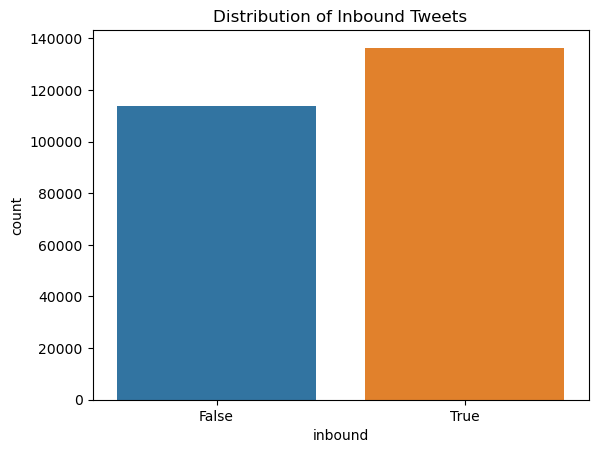

In [12]:
# EDA Functions
def plot_tweet_distribution(df, column='inbound'):
    """
    Visualize the distribution of tweets.
    """
    sns.countplot(x=column, data=df)
    plt.title(f'Distribution of {column.capitalize()} Tweets')
    plt.show()

# plotting the distribution
plot_tweet_distribution(df=df)

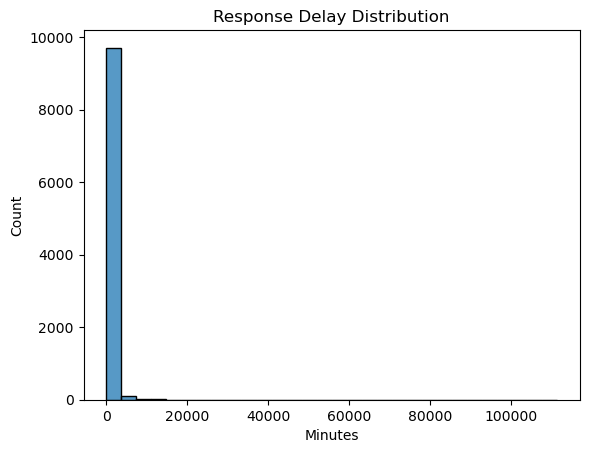

In [13]:
# conversation flow analysis plot
def conversation_flow_analysis(df):
    """
    Analyze the flow of conversations by looking at response delays.
    """
    df['response_delay'] = (df['created_at_outbound'] - df['created_at_inbound']).dt.total_seconds() / 60
    sns.histplot(df['response_delay'], bins=30)
    plt.title('Response Delay Distribution')
    plt.xlabel('Minutes')
    plt.show()

conversation_flow_analysis(df=df_linked)

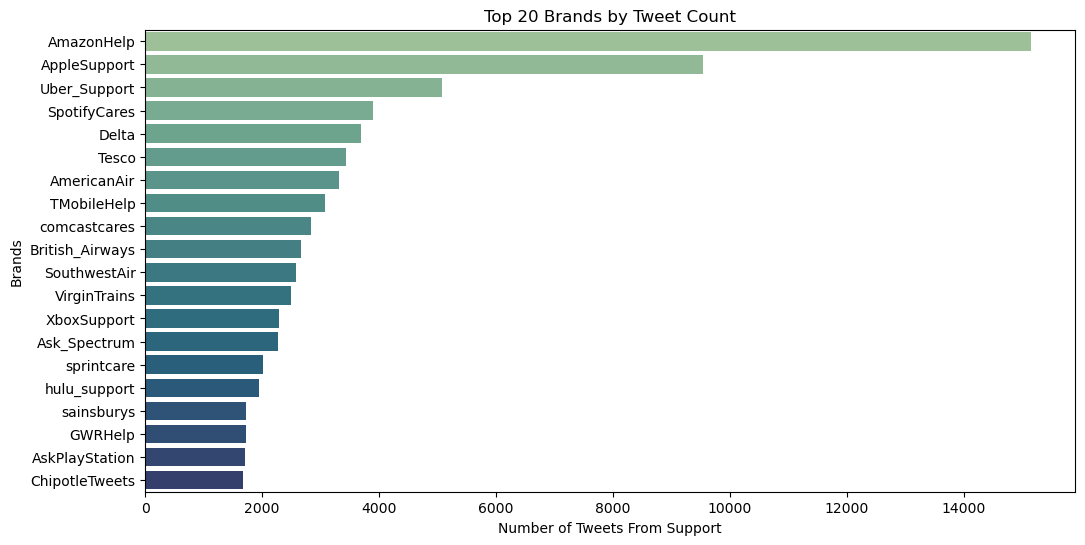

In [14]:
# Plotting the frequency distribution of brands (author_id)
brand_counts = df['author_id'].value_counts().head(20)  # Top 20 brands
plt.figure(figsize=(12, 6))
sns.barplot(x=brand_counts.values, y=brand_counts.index, palette='crest')
plt.title('Top 20 Brands by Tweet Count')
plt.xlabel('Number of Tweets From Support')
plt.ylabel('Brands')
plt.show() 

#### Transformations for EDA

Aggregating the time period by month and utilizing a moving average with a rolling window of 7 periods to properly visualize the sentiment along with the number of tweets from 2012 onwards. The visualization is a tool to retrieve insights from the data to consider when approaching next development stages.

In [15]:
# rilter the data to include only dates from 2012 onwards
df_filtered = df[df['created_at'].dt.year >= 2012]
# Aggregate sentiment scores by week or month and calculate the mean
# # For monthly average:
monthly_sentiment = df_filtered.resample('M', on='created_at')['sentiment'].mean().reset_index()
# Choose one of the above, then apply a rolling window
rolling_window_size = 7  # 7 periods rolling average
monthly_sentiment['rolling_sentiment'] = monthly_sentiment['sentiment'].rolling(window=rolling_window_size, min_periods=1).mean()

# plotting monthly sentiment 
fig = px.line(monthly_sentiment, x='created_at', y='rolling_sentiment', title='Monthly Sentiment Score Over Time - Rolling Average')
fig.update_xaxes(title_text='Time')
fig.update_yaxes(title_text='Average Sentiment Score')
fig.show()

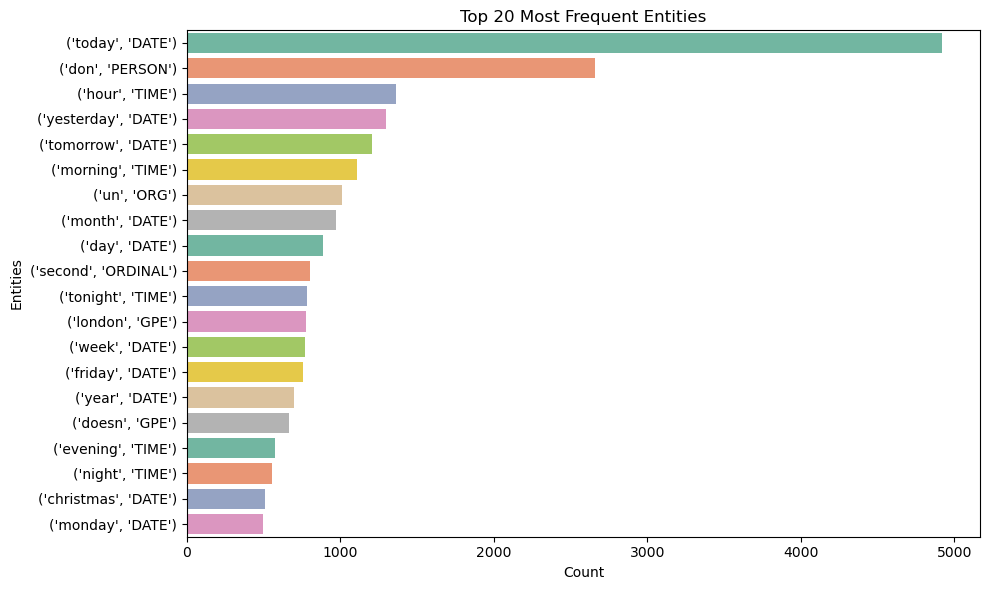

In [16]:
# function to identify the top entities with the NER column created
def most_frequent_entities(df, column='entities', top_n=20):
    """
    Find and visualize the most frequent entities in a DataFrame.
    df (pd.DataFrame): DataFrame containing the entities.
    column (str): The name of the column in df that contains the entities.
    top_n (int): The number of top entities to return.
    Returns:
    pd.DataFrame: A DataFrame containing the top entities and their counts.
    """
    # Flatten the list of entities
    all_entities = [ent for sublist in df[column] for ent in sublist]
    # Count the entities
    entity_counts = Counter(all_entities)
    # Get the top n entities
    top_entities = entity_counts.most_common(top_n)
    # Convert to DataFrame for better visualization
    top_entities_df = pd.DataFrame(top_entities, columns=['Entity', 'Count'])
    
    # Plotting
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Count', y='Entity', data=top_entities_df, palette='Set2')
    plt.title(f'Top {top_n} Most Frequent Entities')
    plt.xlabel('Count')
    plt.ylabel('Entities')
    plt.tight_layout()
    plt.show()

    return top_entities_df
# applying the function and visualizing the top entities
top_entities_df = most_frequent_entities(df)

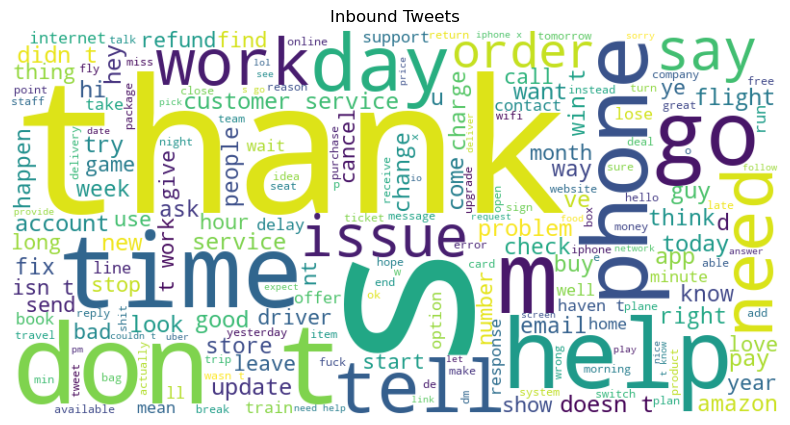

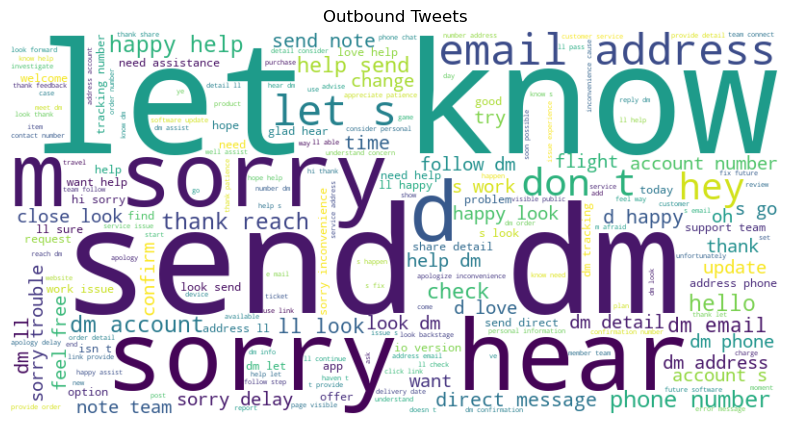

In [17]:

# generate word clouds functiion 
def generate_word_clouds(df):
    inbound_text = ' '.join(df[df['inbound']]['processed_text'].dropna())
    outbound_text = ' '.join(df[~df['inbound']]['processed_text'].dropna())

    for text, title in zip([inbound_text, outbound_text], ['Inbound Tweets', 'Outbound Tweets']):
        wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', width=800, height=400).generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(title)
        plt.axis('off')
        plt.show()
    return wordcloud

# applying the function
generate_word_clouds(df)

In [18]:
# creating a function: perform topic modeling 
def perform_topic_modeling(df, column='processed_text', num_topics_range=(5, 15), workers=None):
    # Filter out None values before applying any text processing
    df = df.dropna(subset=[column])
    
    # Continue with processing as before
    texts = df[column].apply(lambda x: x.split())
    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    best_coherence = 0
    best_model = None
    best_num_topics = 0
    
    for num_topics in range(*num_topics_range, 5):  # Using a step of 5 for a broader search
        model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, workers=workers, passes=5)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_score = coherencemodel.get_coherence()
        
        if coherence_score > best_coherence:
            best_coherence = coherence_score
            best_model = model
            best_num_topics = num_topics
    
    print(f"Initial Exploration - Best Number of Topics: {best_num_topics}, Coherence Score: {best_coherence}")
    return best_model, best_num_topics

# Adjust num_topics_range based on your initial exploration needs
best_model, best_num_topics = perform_topic_modeling(df, num_topics_range=(5, 15), workers=4)

2023-11-24 11:35:51,702 - INFO - adding document #0 to Dictionary<0 unique tokens: []>
2023-11-24 11:35:51,787 - INFO - adding document #10000 to Dictionary<9659 unique tokens: ['confirm', 'detail', 'dm', 'request', 'thank']...>
2023-11-24 11:35:51,872 - INFO - adding document #20000 to Dictionary<13873 unique tokens: ['confirm', 'detail', 'dm', 'request', 'thank']...>
2023-11-24 11:35:51,957 - INFO - adding document #30000 to Dictionary<17285 unique tokens: ['confirm', 'detail', 'dm', 'request', 'thank']...>
2023-11-24 11:35:52,048 - INFO - adding document #40000 to Dictionary<20202 unique tokens: ['confirm', 'detail', 'dm', 'request', 'thank']...>
2023-11-24 11:35:52,136 - INFO - adding document #50000 to Dictionary<22773 unique tokens: ['confirm', 'detail', 'dm', 'request', 'thank']...>
2023-11-24 11:35:52,223 - INFO - adding document #60000 to Dictionary<24939 unique tokens: ['confirm', 'detail', 'dm', 'request', 'thank']...>
2023-11-24 11:35:52,313 - INFO - adding document #70000 

Initial Exploration - Best Number of Topics: 10, Coherence Score: 0.5049117859936576


In [19]:
print('This is the best model '+ str(best_model))

This is the best model LdaMulticore<num_terms=51915, num_topics=10, decay=0.5, chunksize=2000>


In [20]:
# function to save models
def save_model(model, model_path):
    """
    Saves the given model to the specified path.
    model: The machine learning model to be saved.
    model_path (str): The path where the model should be saved.
    """
    try:
        # Ensure the directory exists
        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        
        # Save the model
        model.save(model_path)
        logging.info(f"Model saved successfully at {model_path}")
    except Exception as e:
        logging.error(f"Error saving the model: {e}")

# applying function
model_path = '../models/lda_best_model.gensim'
save_model(best_model, model_path)


2023-11-24 11:40:54,646 - INFO - LdaState lifecycle event {'fname_or_handle': '../models/lda_best_model.gensim.state', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2023-11-24T11:40:54.646832', 'gensim': '4.3.2', 'python': '3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:42:20) \n[Clang 14.0.6 ]', 'platform': 'macOS-14.0-x86_64-i386-64bit', 'event': 'saving'}
2023-11-24 11:40:54,650 - INFO - saved ../models/lda_best_model.gensim.state
2023-11-24 11:40:54,671 - INFO - LdaMulticore lifecycle event {'fname_or_handle': '../models/lda_best_model.gensim', 'separately': "['expElogbeta', 'sstats']", 'sep_limit': 10485760, 'ignore': ['id2word', 'state', 'dispatcher'], 'datetime': '2023-11-24T11:40:54.671378', 'gensim': '4.3.2', 'python': '3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:42:20) \n[Clang 14.0.6 ]', 'platform': 'macOS-14.0-x86_64-i386-64bit', 'event': 'saving'}
2023-11-24 11:40:54,672 - INFO - storing np array 'expElogbeta' to 

In [23]:
# function to assing topic column to cleaned df
def assign_topics(df, lda_model, dictionary, text_column='processed_text'):
    """
    Assigns the most probable topic to each document in the DataFrame using a trained LDA model.
    Args:
        df (pd.DataFrame): DataFrame containing the text data.
        lda_model (LdaMulticore): Trained LDA model.
        dictionary (Dictionary): Gensim dictionary used for the LDA model.
        text_column (str): Name of the column in df containing the text data.
    Returns:
        pd.DataFrame: DataFrame with an additional 'topic' column.
    """
    def get_most_probable_topic(text):
        try:
            # Check for None or NaN
            if text is None or pd.isna(text):
                return None
            bow = dictionary.doc2bow(text.split())
            topic_distribution = lda_model.get_document_topics(bow)
            most_probable_topic, _ = max(topic_distribution, key=lambda item: item[1])
            return most_probable_topic
        except Exception as e:
            logging.error(f"Error in getting most probable topic: {e}")
            return None

    try:
        df['topic'] = df[text_column].apply(get_most_probable_topic)
        logging.info("Topics assigned successfully.")
    except Exception as e:
        logging.error(f"Error in assigning topics to DataFrame: {e}")

    return df

# Preparing the dictionary outside of the function
texts = df['processed_text'].dropna().apply(lambda x: x.split())
dictionary = corpora.Dictionary(texts)

# Apply the function to your DataFrame
df = assign_topics(df, best_model, dictionary)

2023-11-24 12:26:14,904 - INFO - adding document #0 to Dictionary<0 unique tokens: []>
2023-11-24 12:26:14,998 - INFO - adding document #10000 to Dictionary<9659 unique tokens: ['confirm', 'detail', 'dm', 'request', 'thank']...>
2023-11-24 12:26:15,095 - INFO - adding document #20000 to Dictionary<13873 unique tokens: ['confirm', 'detail', 'dm', 'request', 'thank']...>
2023-11-24 12:26:15,189 - INFO - adding document #30000 to Dictionary<17285 unique tokens: ['confirm', 'detail', 'dm', 'request', 'thank']...>
2023-11-24 12:26:15,279 - INFO - adding document #40000 to Dictionary<20202 unique tokens: ['confirm', 'detail', 'dm', 'request', 'thank']...>
2023-11-24 12:26:15,368 - INFO - adding document #50000 to Dictionary<22773 unique tokens: ['confirm', 'detail', 'dm', 'request', 'thank']...>
2023-11-24 12:26:15,469 - INFO - adding document #60000 to Dictionary<24939 unique tokens: ['confirm', 'detail', 'dm', 'request', 'thank']...>
2023-11-24 12:26:15,571 - INFO - adding document #70000 

In [24]:
# function to save data
def save_data(df, folder_path, file_name):
    """
    Saves the given DataFrame to a CSV file within the specified folder.
    df (pd.DataFrame): The DataFrame to be saved.
    folder_path (str): The path to the folder where the CSV file will be saved.
    file_name (str): The name of the CSV file.
    Returns:
    str: The full path to the saved CSV file, or None if an error occurred.
    """
    try:
        # Ensure the directory exists
        os.makedirs(folder_path, exist_ok=True)

        # Full path for the CSV file
        full_path = os.path.join(folder_path, file_name)

        # Save the DataFrame to CSV
        df.to_csv(full_path, index=False)
        
        logging.info(f"DataFrame saved successfully to {full_path}")
        return full_path
    except Exception as e:
        logging.error(f"Error saving the DataFrame to CSV: {e}")
        return None
# saving data
folder_path = '../data/'  # Adjust the path as needed
file_name = 'interim/cleaned_data.csv'
full_path = save_data(df, folder_path, file_name)

if full_path:
    print(f"DataFrame saved at: {full_path}")
else:
    print("Failed to save the DataFrame.")

2023-11-24 12:27:13,185 - INFO - DataFrame saved successfully to ../data/interim/cleaned_data.csv


DataFrame saved at: ../data/interim/cleaned_data.csv


In [29]:
folder_path1 = '../data/'  # Adjust the path as needed
file_name1 = 'interim/linked_data.csv'
full_path1 = save_data(df_linked, folder_path1, file_name1)

if full_path:
    print(f"DataFrame saved at: {full_path}")
else:
    print("Failed to save the DataFrame.")

2023-11-24 16:46:11,496 - INFO - DataFrame saved successfully to ../data/interim/linked_data.csv


DataFrame saved at: ../data/interim/cleaned_data.csv


In [28]:
df['processed_text'][0]

'confirm request detail dm thank'

In [27]:
df.head(20)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,cleaned_text,processed_text,pos_tags,dep_parse,sentiment,entities,sentiment_class,topic
0,2149594,Tesco,False,2017-11-09 00:55:53,@535047 Can you please confirm the requested d...,NaN,2149595.0,can you please confirm the requested details i...,confirm request detail dm thank,"[AUX, PRON, INTJ, VERB, DET, VERB, NOUN, ADP, ...","[aux, nsubj, intj, ROOT, det, amod, dobj, prep...",0.3612,[],Positive,8.0
1,1561881,482478,True,2017-11-04 04:57:53,What's with the pricing @GoDaddyHelp?\n$12.96....,"1561882,1561883,1561880",NaN,what s with the pricing ok t cs state ican ok ...,s pricing ok t cs state ican ok add option ok ...,"[PRON, VERB, ADP, DET, NOUN, INTJ, PROPN, PROP...","[nsubj, csubj, prep, det, pobj, prep, nmod, co...",0.6808,[],Positive,5.0
2,1956537,SpotifyCares,False,2017-10-30 17:24:43,@580626 Hey Henry! It's an easter egg for the ...,NaN,1956538.0,hey henry it s an easter egg for the netflix s...,hey henry s easter egg netflix strange thing t...,"[INTJ, INTJ, PRON, VERB, DET, ADJ, NOUN, ADP, ...","[intj, intj, nsubj, ROOT, det, amod, attr, pre...",-0.3818,"[(henry s, PERSON), (netflix, GPE)]",Negative,1.0
3,1495379,AskCiti,False,2017-11-05 00:32:31,@467204 Hello. We haven't heard from u. If u s...,NaN,1495377.0,hello we haven t heard from u if u still requi...,hello haven t hear u u require assistance pls ...,"[INTJ, PRON, VERB, PROPN, VERB, ADP, PROPN, SC...","[intj, nsubj, ROOT, nsubj, ccomp, prep, pobj, ...",0.4215,[],Positive,3.0
4,582530,ATVIAssist,False,2017-12-03 13:19:03,"@257338 Apologies for the delay, please provid...",NaN,582531.0,apologies for the delay please provide us more...,apology delay provide detail include gamer tag...,"[NOUN, ADP, DET, NOUN, INTJ, VERB, PRON, ADJ, ...","[nsubj, prep, det, pobj, intj, ROOT, dative, a...",0.1531,[],Neutral,3.0
5,2077646,135058,True,2017-10-09 07:41:35,"@AppleSupport hey, I didn’t use a flashlight m...","2077647,2077645",NaN,hey i didn t use a flashlight many days but it...,hey didn t use flashlight day take battery hou...,"[INTJ, PRON, PROPN, PROPN, VERB, DET, NOUN, AD...","[intj, nsubj, compound, appos, ROOT, det, dobj...",0.0000,"[(yesterday, DATE)]",Neutral,5.0
6,1067207,371845,True,2017-10-14 20:26:51,@115888 funny how a song that brags about sayi...,1067206,NaN,funny how a song that brags about saying fuck ...,funny song brag say fuck time isn t explicit,"[ADJ, SCONJ, DET, NOUN, PRON, VERB, ADP, VERB,...","[ROOT, advmod, det, nsubj, nsubj, relcl, prep,...",-0.1531,[],Neutral,5.0
7,2792850,UPSHelp,False,2017-11-21 21:08:00,"@779420 Also, with your phone number I can fil...",2792851,2792852.0,also with your phone number i can file your co...,phone number file complaint provide detail com...,"[ADV, ADP, PRON, NOUN, NOUN, PRON, AUX, VERB, ...","[advmod, prep, poss, compound, pobj, nsubj, au...",-0.1531,[],Neutral,3.0
8,2181045,639075,True,2017-11-09 18:31:34,@VirginTrains Now I'm connected and slow! Not ...,2181046,2181044.0,now i m connected and slow not as good as the ...,m connected slow good outbound journey,"[ADV, PRON, AUX, ADJ, CCONJ, ADJ, PART, ADV, A...","[advmod, nsubjpass, auxpass, ROOT, cc, conj, n...",0.4404,[],Positive,6.0
9,2737067,comcastcares,False,2017-11-20 20:39:51,@766954 The last DM from you was in July. We w...,NaN,2737065.0,the last dm from you was in july we would need...,dm july need send dm service address phone num...,"[DET, ADJ, NOUN, ADP, PRON, AUX, ADP, PROPN, P...","[det, amod, nsubj, prep, pobj, ccomp, prep, po...",0.0772,"[(july, DATE)]",Neutral,3.0
